In [0]:
import pandas as pd
uri = "https://gist.githubusercontent.com/guilhermesilveira/4d1d4a16ccbf6ea4e0a64a38a24ec884/raw/afd05cb0c796d18f3f5a6537053ded308ba94bf7/car-prices.csv"
dados = pd.read_csv(uri)
dados.head()

,Unnamed: 0,mileage_per_year,model_year,price,sold
0,0,21801,2000,30941.02,yes
1,1,7843,1998,40557.96,yes
2,2,7109,2006,89627.50,no
3,3,26823,2015,95276.14,no
4,4,7935,2014,117384.68,yes


# Fazer algorítmos para prever se o carro será vendido ou não de acordo com as características do mesmo (kilometragem por ano, ano do modelo e preço) - Uso de algorítmos supervisionados
Com este algorítmo podemos ajudar o cliente a mudar o valor do carro (pois os outros parâmetros não podem ser mudados - ano e kilometragem) para vender melhor

#1 - Corrigir nomes das colunas para português

In [0]:
a_renomear = {
    'mileage_per_year' : 'milhas_por_ano',
    'model_year' : 'ano_do_modelo',
    'price' :'preco',
    'sold' : 'vendido'
}
dados = dados.rename(columns=a_renomear)
dados.head()

,Unnamed: 0,milhas_por_ano,ano_do_modelo,preco,vendido
0,0,21801,2000,30941.02,yes
1,1,7843,1998,40557.96,yes
2,2,7109,2006,89627.50,no
3,3,26823,2015,95276.14,no
4,4,7935,2014,117384.68,yes


#2 - Corrigir yes e no da coluna vendido para 0 e 1 (facilitará na estimativa futura dos dados)

In [0]:
a_trocar = {
    'no' : 0,
    'yes': 1
}
dados.vendido = dados.vendido.map(a_trocar)
dados.head()

,Unnamed: 0,milhas_por_ano,ano_do_modelo,preco,vendido
0,0,21801,2000,30941.02,1
1,1,7843,1998,40557.96,1
2,2,7109,2006,89627.50,0
3,3,26823,2015,95276.14,0
4,4,7935,2014,117384.68,1


#3 - Criar coluna com a idade do modelo, pois se usarmos o ano, as diferenças serão muito pequenas se comparadas ao número inteiro (2 anos comparados com 2015, por exemplo). Mesmo com o scaler corrigindo isto, para melhor entendimento do uso dos dados, faremos esta alteração

In [0]:
from datetime import datetime
ano_atual = datetime.today().year


In [0]:
ano_atual

2019

In [0]:
dados['idade_do_modelo'] = ano_atual - dados.ano_do_modelo
dados.head()

,Unnamed: 0,milhas_por_ano,ano_do_modelo,preco,vendido,idade_do_modelo
0,0,21801,2000,30941.02,1,19
1,1,7843,1998,40557.96,1,21
2,2,7109,2006,89627.50,0,13
3,3,26823,2015,95276.14,0,4
4,4,7935,2014,117384.68,1,5


#4 - Fazer a conversão das milhas por ano para kilômetros por ano (1 milha = 1,60934, segundo google ;)

In [0]:
dados['km_por_ano'] = dados.milhas_por_ano * 1.60934
dados.head()

,Unnamed: 0,milhas_por_ano,ano_do_modelo,preco,vendido,idade_do_modelo,km_por_ano
0,0,21801,2000,30941.02,1,19,35085.22134
1,1,7843,1998,40557.96,1,21,12622.05362
2,2,7109,2006,89627.50,0,13,11440.79806
3,3,26823,2015,95276.14,0,4,43167.32682
4,4,7935,2014,117384.68,1,5,12770.11290


#5 - Limpar os dados que não serão usados
Usar drop (por padrão o drop retira linhas, cuidado!)

In [0]:
dados = dados.drop(columns = ["Unnamed: 0", "milhas_por_ano", "ano_do_modelo"], axis=1)

In [0]:
dados.head()

,preco,vendido,idade_do_modelo,km_por_ano
0,30941.02,1,19,35085.22134
1,40557.96,1,21,12622.05362
2,89627.50,0,13,11440.79806
3,95276.14,0,4,43167.32682
4,117384.68,1,5,12770.11290


#6 - Testar aproximação linear com o conjunto de dados atual

In [0]:
x = dados[["preco", "idade_do_modelo", "km_por_ano"]]
y = dados["vendido"]

from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
import numpy as np

SEED = 33
np.random.seed(SEED)

treino_x, teste_x, treino_y, teste_y = train_test_split(x, y, 
                                                        test_size = 0.25, 
                                                        stratify = y)

print("Treinaremos com %d elementos e testaremos com %d elementos" % (len(treino_x), len(teste_x)))



modelo = LinearSVC(max_iter=100000) #tentar aumentar o númeromáximo de iterações para melhorar a aproximação
modelo.fit(treino_x, treino_y) 

previsoes = modelo.predict(teste_x)

taxa_de_acerto = accuracy_score(teste_y, previsoes)*100

print("A taxa de acertos para esta previsão é de %.2f%%"  % taxa_de_acerto)

Treinaremos com 7500 elementos e testaremos com 2500 elementos
A taxa de acertos para esta previsão é de 58.72%


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


#Ainda não sabemos se este resultado é bom ou ruim. Para mensurarmos isto, vamos testar com um baseline
Usar o dummy do sklearn

In [0]:
from sklearn.dummy import DummyClassifier

dummy_stratified = DummyClassifier() # o mesmo que dummy_stratified = DummyClassifier(strategy='stratified')
dummy_stratified.fit(treino_x, treino_y) 

previsoes = dummy_stratified.predict(teste_x)


taxa_de_acerto = accuracy_score(teste_y, previsoes)*100

print("A taxa de acertos para esta previsão é de %.2f%%"  % taxa_de_acerto)


A taxa de acertos para esta previsão é de 51.28%


In [0]:
from sklearn.dummy import DummyClassifier

dummy_mostfrequent = DummyClassifier(strategy='most_frequent')
dummy_mostfrequent.fit(treino_x, treino_y) 

taxa_de_acerto = dummy_mostfrequent.score(teste_x,teste_y)*100 #Usamos o score do dummy para economizar código

print("A taxa de acertos para esta previsão é de %.2f%%"  % taxa_de_acerto)


A taxa de acertos para esta previsão é de 58.00%


#7 - Testar outros tipos de aproximação
Ex.: SVC

In [0]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.dummy import DummyClassifier

SEED = 33
np.random.seed(SEED)

original_treino_x, original_teste_x, treino_y, teste_y = train_test_split(x, y, 
                                                        test_size = 0.25, 
                                                        stratify = y)

print("Treinaremos com %d elementos e testaremos com %d elementos" % (len(treino_x), len(teste_x)))

scaler = StandardScaler() #cria o escalador
scaler.fit(original_treino_x) #treina o escalador com os dados de treino
treino_x = scaler.transform(original_treino_x) #transforma a escala dos dados de treino_x
teste_x = scaler.transform(original_teste_x) #transforma a escala dos dados de teste_x

modelo = SVC(gamma = 'auto')
modelo.fit(treino_x, treino_y) 

previsoes = modelo.predict(teste_x)

taxa_de_acerto = accuracy_score(teste_y, previsoes)*100

print("A taxa de acertos para esta previsão é de %.2f%%"  % taxa_de_acerto)

Treinaremos com 7500 elementos e testaremos com 2500 elementos
A taxa de acertos para esta previsão é de 77.00%


#Resovido!!??? Como saber como a decisão estão sendo tomadas? Qual a regra de decisão? - Árvores de decisão

#1 - Usando Decision Tree Classifier do SKLEARN

In [0]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.dummy import DummyClassifier

SEED = 33
np.random.seed(SEED)

original_treino_x, original_teste_x, treino_y, teste_y = train_test_split(x, y, 
                                                        test_size = 0.25, 
                                                        stratify = y)

print("Treinaremos com %d elementos e testaremos com %d elementos" % (len(treino_x), len(teste_x)))

scaler = StandardScaler() #cria o escalador
scaler.fit(original_treino_x) #treina o escalador com os dados de treino
treino_x = scaler.transform(original_treino_x) #transforma a escala dos dados de treino_x
teste_x = scaler.transform(original_teste_x) #transforma a escala dos dados de teste_x

modelo = DecisionTreeClassifier()
modelo.fit(treino_x, treino_y) 

previsoes = modelo.predict(teste_x)

taxa_de_acerto = accuracy_score(teste_y, previsoes)*100

print("A taxa de acertos para esta previsão é de %.2f%%"  % taxa_de_acerto)

Treinaremos com 7500 elementos e testaremos com 2500 elementos
A taxa de acertos para esta previsão é de 71.52%


In [0]:
from sklearn.tree import export_graphviz

export_graphviz(modelo)
#export_graphviz(modelo, out_file=None) Caso necessário (depende da versão da biblioteca do sklearn)

'digraph Tree {\nnode [shape=box] ;\n0 [label="X[0] <= -0.196\\ngini = 0.487\\nsamples = 7500\\nvalue = [3150, 4350]"] ;\n1 [label="X[0] <= -0.982\\ngini = 0.197\\nsamples = 3240\\nvalue = [359, 2881]"] ;\n0 -> 1 [labeldistance=2.5, labelangle=45, headlabel="True"] ;\n2 [label="gini = 0.0\\nsamples = 1448\\nvalue = [0, 1448]"] ;\n1 -> 2 ;\n3 [label="X[2] <= 1.622\\ngini = 0.32\\nsamples = 1792\\nvalue = [359, 1433]"] ;\n1 -> 3 ;\n4 [label="X[2] <= -1.427\\ngini = 0.31\\nsamples = 1661\\nvalue = [319, 1342]"] ;\n3 -> 4 ;\n5 [label="X[2] <= -1.433\\ngini = 0.433\\nsamples = 60\\nvalue = [19, 41]"] ;\n4 -> 5 ;\n6 [label="X[0] <= -0.632\\ngini = 0.414\\nsamples = 58\\nvalue = [17, 41]"] ;\n5 -> 6 ;\n7 [label="X[0] <= -0.657\\ngini = 0.488\\nsamples = 26\\nvalue = [11, 15]"] ;\n6 -> 7 ;\n8 [label="X[0] <= -0.751\\ngini = 0.454\\nsamples = 23\\nvalue = [8, 15]"] ;\n7 -> 8 ;\n9 [label="X[1] <= -0.923\\ngini = 0.498\\nsamples = 15\\nvalue = [7, 8]"] ;\n8 -> 9 ;\n10 [label="gini = 0.0\\nsamples

In [0]:
import graphviz
dot_data = export_graphviz(modelo)
grafico = graphviz.Source(dot_data)
grafico

Output hidden; open in https://colab.research.google.com to view.

#Sem limitação da profundidade nesta árvore de decisão, o gráfico ficou muito grande.
#Vamos limitar para uma profundidade igual a dois níveis:

Treinaremos com 7500 elementos e testaremos com 2500 elementos
A taxa de acertos para esta previsão é de 76.28%


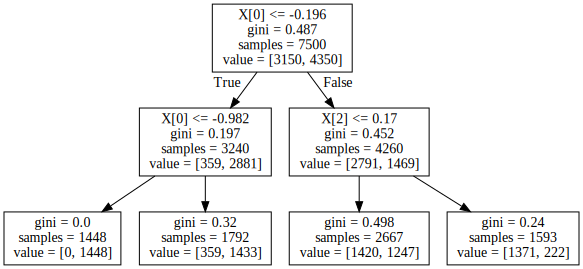

In [0]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.dummy import DummyClassifier

SEED = 33
np.random.seed(SEED)

original_treino_x, original_teste_x, treino_y, teste_y = train_test_split(x, y, 
                                                        test_size = 0.25, 
                                                        stratify = y)

print("Treinaremos com %d elementos e testaremos com %d elementos" % (len(treino_x), len(teste_x)))

scaler = StandardScaler() #cria o escalador
scaler.fit(original_treino_x) #treina o escalador com os dados de treino
treino_x = scaler.transform(original_treino_x) #transforma a escala dos dados de treino_x
teste_x = scaler.transform(original_teste_x) #transforma a escala dos dados de teste_x

modelo = DecisionTreeClassifier(max_depth=2)
modelo.fit(treino_x, treino_y) 

previsoes = modelo.predict(teste_x)

taxa_de_acerto = accuracy_score(teste_y, previsoes)*100

print("A taxa de acertos para esta previsão é de %.2f%%"  % taxa_de_acerto)

from sklearn.tree import export_graphviz

export_graphviz(modelo)

import graphviz
dot_data = export_graphviz(modelo)
grafico = graphviz.Source(dot_data)
grafico

#Para melhorar ainda mais a visualização, vamos mudar os nomes das features de X[0] à X[2] para os nomes das colunas que estamos usando:

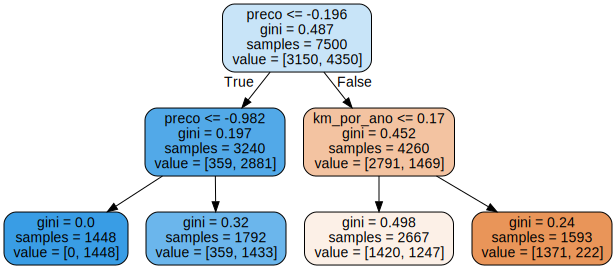

In [0]:
from sklearn.tree import export_graphviz
import graphviz

features = x.columns
dot_data = export_graphviz(modelo, out_file=None,
                           filled = True, rounded = True,
                          feature_names = features)
grafico = graphviz.Source(dot_data)
grafico

#Melhorando a visualização:

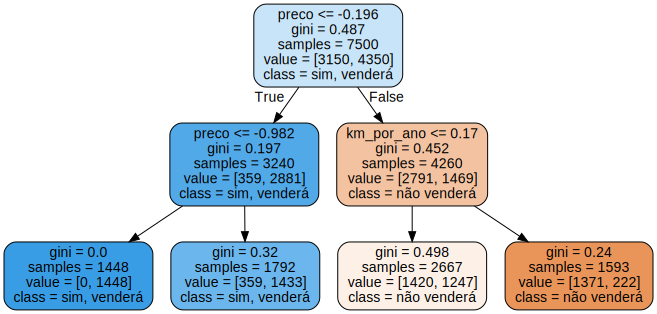

In [0]:
from sklearn.tree import export_graphviz
import graphviz

features = x.columns
dot_data = export_graphviz(modelo, out_file=None,
                           filled = True, rounded = True,
                          feature_names = features,
                          class_names = ["não venderá", "sim, venderá"])
grafico = graphviz.Source(dot_data)
grafico

#Como as árvores de decisão não precisam do escalador para funcionar bem, vamois retirar ele e rodar novamente para corrigir os preços

Treinaremos com 7500 elementos e testaremos com 2500 elementos
A taxa de acertos para esta previsão é de 76.28%


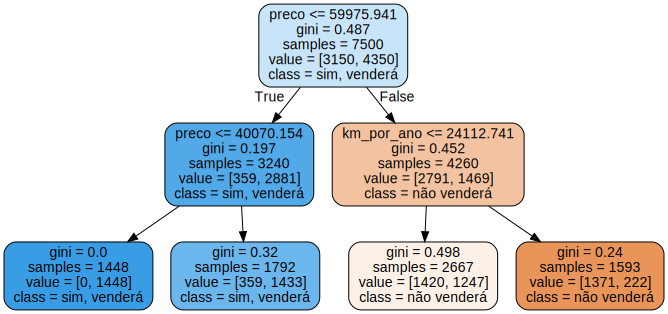

In [0]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.dummy import DummyClassifier

SEED = 33
np.random.seed(SEED)

original_treino_x, original_teste_x, treino_y, teste_y = train_test_split(x, y, 
                                                        test_size = 0.25, 
                                                        stratify = y)

print("Treinaremos com %d elementos e testaremos com %d elementos" % (len(treino_x), len(teste_x)))

#scaler = StandardScaler() #cria o escalador
#scaler.fit(original_treino_x) #treina o escalador com os dados de treino
#treino_x = scaler.transform(original_treino_x) #transforma a escala dos dados de treino_x
#teste_x = scaler.transform(original_teste_x) #transforma a escala dos dados de teste_x

modelo = DecisionTreeClassifier(max_depth=2)
modelo.fit(original_treino_x, treino_y) 

previsoes = modelo.predict(original_teste_x)

taxa_de_acerto = accuracy_score(teste_y, previsoes)*100

print("A taxa de acertos para esta previsão é de %.2f%%"  % taxa_de_acerto)

from sklearn.tree import export_graphviz

export_graphviz(modelo)

import graphviz
features = x.columns
dot_data = export_graphviz(modelo, out_file=None,
                           filled = True, rounded = True,
                          feature_names = features,
                          class_names = ["não venderá", "sim, venderá"])
grafico = graphviz.Source(dot_data)
grafico

Treinaremos com 7500 elementos e testaremos com 2500 elementos
A taxa de acertos para esta previsão é de 79.00%


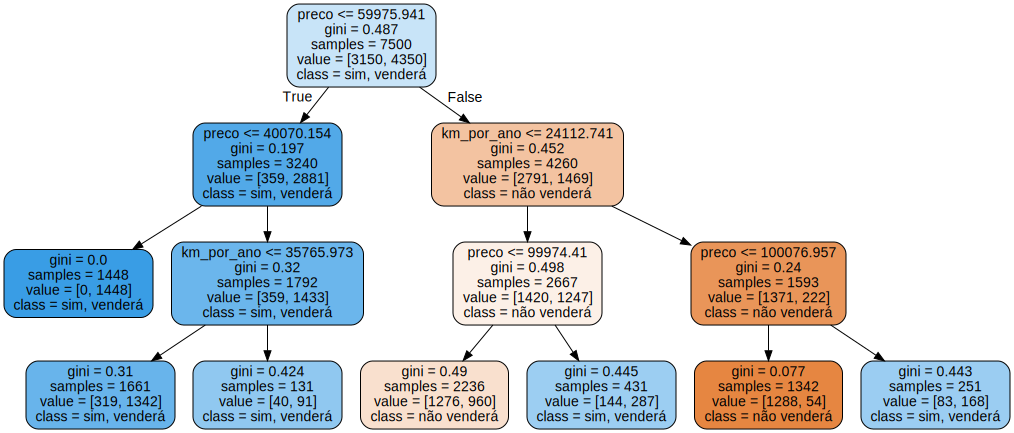

In [0]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.dummy import DummyClassifier

SEED = 33
np.random.seed(SEED)

original_treino_x, original_teste_x, treino_y, teste_y = train_test_split(x, y, 
                                                        test_size = 0.25, 
                                                        stratify = y)

print("Treinaremos com %d elementos e testaremos com %d elementos" % (len(treino_x), len(teste_x)))

#scaler = StandardScaler() #cria o escalador
#scaler.fit(original_treino_x) #treina o escalador com os dados de treino
#treino_x = scaler.transform(original_treino_x) #transforma a escala dos dados de treino_x
#teste_x = scaler.transform(original_teste_x) #transforma a escala dos dados de teste_x

modelo = DecisionTreeClassifier(max_depth=3)
modelo.fit(original_treino_x, treino_y) 

previsoes = modelo.predict(original_teste_x)

taxa_de_acerto = accuracy_score(teste_y, previsoes)*100

print("A taxa de acertos para esta previsão é de %.2f%%"  % taxa_de_acerto)

from sklearn.tree import export_graphviz

export_graphviz(modelo)

import graphviz
features = x.columns
dot_data = export_graphviz(modelo, out_file=None,
                           filled = True, rounded = True,
                          feature_names = features,
                          class_names = ["não venderá", "sim, venderá"])
grafico = graphviz.Source(dot_data)
grafico

In [0]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.dummy import DummyClassifier

SEED = 33
np.random.seed(SEED)

original_treino_x, original_teste_x, treino_y, teste_y = train_test_split(x, y, 
                                                        test_size = 0.25, 
                                                        stratify = y)

print("Treinaremos com %d elementos e testaremos com %d elementos" % (len(treino_x), len(teste_x)))

#scaler = StandardScaler() #cria o escalador
#scaler.fit(original_treino_x) #treina o escalador com os dados de treino
#treino_x = scaler.transform(original_treino_x) #transforma a escala dos dados de treino_x
#teste_x = scaler.transform(original_teste_x) #transforma a escala dos dados de teste_x

modelo = DecisionTreeClassifier()
modelo.fit(original_treino_x, treino_y) 

previsoes = modelo.predict(original_teste_x)

taxa_de_acerto = accuracy_score(teste_y, previsoes)*100

print("A taxa de acertos para esta previsão é de %.2f%%"  % taxa_de_acerto)

from sklearn.tree import export_graphviz

export_graphviz(modelo)

import graphviz
features = x.columns
dot_data = export_graphviz(modelo, out_file=None,
                           filled = True, rounded = True,
                          feature_names = features,
                          class_names = ["não venderá", "sim, venderá"])
grafico = graphviz.Source(dot_data)
grafico

Output hidden; open in https://colab.research.google.com to view.